<a href="https://colab.research.google.com/github/daasem1project/AppleMD/blob/master/AppleMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apple Disease Detection
(Using Vit + LLM [ prompt engineering ])

Block Diagram of the Vision Transformer <br>
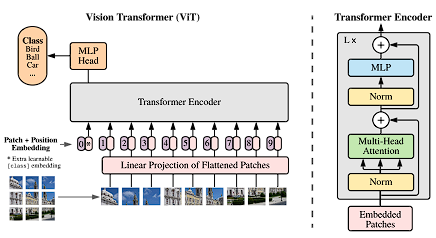

In [ ]:
# Delete dataset
! rm -rf /content/apple_disease_dataset

In [ ]:
# Downloading dataset from drive
from google.colab import drive
drive.mount('/content/gdrive')

!cp -r '/content/gdrive/My Drive/apple_disease_dataset' /content/

Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, Softmax, LayerNormalization, MultiHeadAttention

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32
RNG_SEED = 100
PATCH_DIM = 16
assert IMG_HEIGHT % PATCH_DIM == 0
assert IMG_WIDTH % PATCH_DIM == 0
PROJECTION_DIM = (PATCH_DIM ** 2) * 3

NUM_HEADS = 4 # per MSA block
NUM_BLOCKS = 12 # depth of transformer encoder

EPOCHS = 10

TRAINING_DATASET_DIR = '/content/apple_disease_dataset/train'
VALIDATION_DATASET_DIR = TRAINING_DATASET_DIR
TESTING_DATASET_DIR = '/content/apple_disease_dataset/test'

In [ ]:
# Importing Images
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAINING_DATASET_DIR,
  validation_split=0.2,
  subset="training",
  seed=RNG_SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  VALIDATION_DATASET_DIR,
  validation_split=0.2,
  subset="validation",
  seed=RNG_SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  TESTING_DATASET_DIR,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)


Algorithm for extraction of patches from an image :-
1. Generate a kernel(mask) of Dimension PATCH_DIM X PATCH_DIM
2. Move the kernel on top of the image in a convolution like fashion with a stride length of (PATCH_DIM).
3. For every kernel position copy the RGB values of the image portion under the kernel in ROW MAJOR ORDER.
4. Doing this for every kernel position and storing the RGB values into a different buffer results in the patched image.
<br><br>
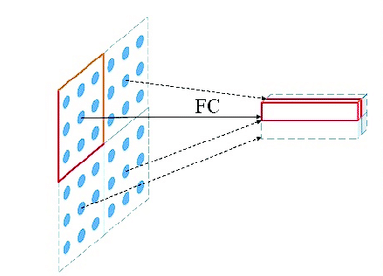

In [ ]:
# Class for creating the patch embedding matrix
class PatchExtractor(Layer):
    def __init__(self):
        super(PatchExtractor, self).__init__()

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, PATCH_DIM, PATCH_DIM, 1],
            strides=[1, PATCH_DIM, PATCH_DIM, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [ ]:
# check for successful loading of images
demo_images, demo_labels = next(iter(train_ds))
demo_image, demo_label = demo_images[0], demo_labels[0]

print("Image tensor dimension : ", end="")
print(demo_image.shape)

# showing first image in batch
plt.imshow(demo_image.numpy().astype("uint8"))
plt.axis("off");
print("Label : ", end="")
print(train_ds.class_names[demo_label])
plt.show()

demo_img_patches = PatchExtractor()(tf.reshape(demo_image, shape=(1, *demo_image.shape)))
print(f"\n\n\nPatch Embedding tensor size : {demo_img_patches.shape}")
n = int(np.sqrt(demo_img_patches.shape[1]))
for i, patch in enumerate(demo_img_patches[0]):
  ax = plt.subplot(n, n, i + 1)
  patch_img = tf.reshape(patch, (PATCH_DIM, PATCH_DIM, 3))
  ax.imshow(patch_img.numpy().astype("uint8"))
  ax.axis("off")
plt.show()

print(f"\n\nThe patch tensor :-")
print(demo_img_patches)


In [ ]:
# this class is responsible for adding positional encoding and also adding the class token to the patch embeddings
class PatchEncoder(Layer):
    def __init__(self, num_patches=(IMG_HEIGHT // PATCH_DIM) ** 2, projection_dim=PROJECTION_DIM):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches+1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        class_token = tf.tile(self.class_token, multiples = [batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [ ]:
# testing PatchEncoder class
demo_encoded_patches = PatchEncoder()(demo_img_patches)
print(f"Encoded Patch Embedding tensor size : {demo_encoded_patches.shape}")

In [ ]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [ ]:
# Multiheaded self-attention, layer normalization and MLP forward in one layer
class Block(Layer):
    def __init__(self, projection_dim, num_heads=4, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        # Create a multi-head attention layer.
        self.msa_block = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x) # encoded_patches
        attention_output = self.msa_block(x1, x1)
        x2 = Add()([attention_output, x])
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        y = Add()([x3, x2])
        return y

In [ ]:
# this layer is a wrapper for the connection of multiple blocks (layer Block)
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=4, num_blocks=12, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.5)

    def call(self, x):
        # Create a [batch_size, projection_dim] tensor.
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        y = self.dropout(x)
        return y

In [ ]:
def construct_VIT(num_classes, num_heads=4, num_blocks=12, num_patches=(IMG_HEIGHT // PATCH_DIM) ** 2, projection_dim=PROJECTION_DIM, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim, num_heads, num_blocks)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    final_output = MLP(projection_dim, num_classes, 0.5)(representation)
    final_output = Softmax()(final_output)
    # Create model
    model = Model(inputs=inputs, outputs=final_output)
    return model

vit_model = construct_VIT(len(train_ds.class_names))
vit_model.summary()

print("\n\n\nBlock Diagram of the VIT model :-")

# model block diagram generator
tf.keras.utils.plot_model(
    vit_model,
#    to_file='/content/vit_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
#    rankdir='TB',
    expand_nested=True,
    dpi=100,
    show_layer_activations=True,
    show_trainable=False,
)

In [ ]:
# training
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}")



<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.10076612, 0.21666947, 0.6591155 , 0.02344895]], dtype=float32)>